# **Text Mining for Data Science** 
## Medical Text Classification - Tasks 2, 4 and 5


Group 1 - 
`Armando Ferreira`
`Fernando Carvalho`

In [17]:
import numpy as np # for numerical operations
import pandas as pd # for data frame manipulation
import matplotlib.pyplot as plt # for plotting
import collections # for counting elements in a list
import string # for string manipulation
import spacy # for natural language processing
import nltk # for natural language processing
import tensorflow as tf # for deep learning
import transformers # for pretrained models

# Set the format of the plots
%config InlineBackend.figure_format = 'svg'

## **1.** Document Pre-processing
#### **1.1.** General

In [18]:
# Read csv file
mtsamples = pd.read_csv('mtsamples.csv', delimiter=';')

# Show the first rows
pd.set_option('display.max_colwidth', None)
mtsamples.tail(2)

# Check for missing values in the medical transcriptions
print(f"Missing values in transcription: {mtsamples['transcription'].isnull().sum()}")

# Delete missing values
mtsamples.dropna(inplace=True)

# Determine the size of the dataset (number of records and features)
print(f"Dataset Shape: {mtsamples.shape}")

Missing values in transcription: 31
Dataset Shape: (3792, 2)


#### **1.2.** Exploratory Data Analysis
##### **1.2.1.** Text Length Analysis

In [25]:
# Calculate the average document length
mtsamples['word_count'] = mtsamples['transcription'].apply(lambda x: len(x.split()))
average_word_count = mtsamples['word_count'].mean()

print(f"Average document length: {round(average_word_count)}")

Average document length: 459


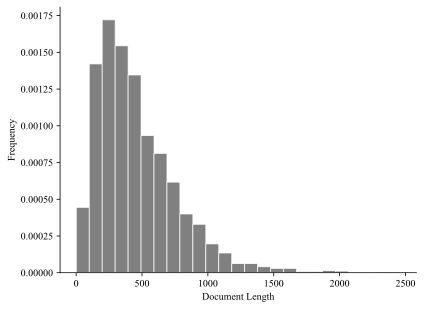

In [26]:
# Plot the distribution of document length
plt.style.use('default')
plt.rc('font', family='Times New Roman', weight='normal')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.hist(mtsamples['word_count'], bins=25, color='grey', edgecolor='white', linewidth=0.7, density=True)
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

<Figure size 1500x600 with 0 Axes>

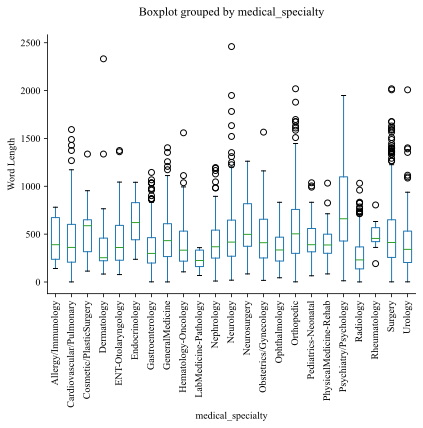

In [27]:
# Plot the boxplots of word length for each medical specialty
plt.figure(figsize=(15, 6))
mtsamples.boxplot(column='word_count', by='medical_specialty', rot=90)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.title('')
plt.grid(False)
plt.ylabel('Word Length')
plt.show()

##### **1.2.2.** Word Frequency

In [ ]:
# Concatenate all transcriptions into a single string
all_transcriptions = ' '.join(mtsamples['transcription'])

# Split the string into individual words
words = all_transcriptions.split()

# Lowercase all words
words = [word.lower() for word in words]

# Remove punctuation
words = [word.translate(str.maketrans('', '', string.punctuation)) for word in words]

# Remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words = [word for word in words if word not in stop_words]

# Remove empty strings
words = [word for word in words if word]

# Count the frequency of each word
tf = collections.Counter(words)  # Define the tf variable
df_word_counts = pd.DataFrame.from_dict(tf, orient='index', columns=['Frequency'])

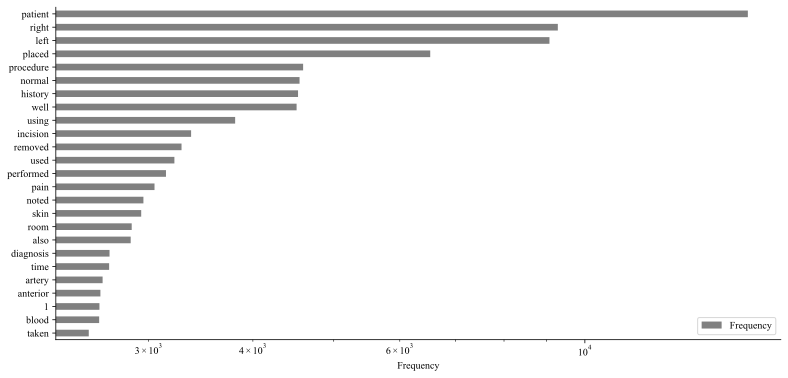

In [29]:
# Plot the word log-frequency for the top 25 words
df_word_counts.sort_values(by='Frequency', ascending=False).head(25).plot(kind='barh', figsize=(13, 6), color='grey')
plt.gca().invert_yaxis()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('Frequency')
plt.xscale('log')
plt.show()

##### **1.2.3.** Target Variable Exploration

In [30]:
# Show the number of unique medical specialties
print(f"Number of specialities (classes): {mtsamples['medical_specialty'].nunique()}")
      
# Analyze the distribution of the medical specialities
print(mtsamples['medical_specialty'].value_counts())

Number of specialities (classes): 23
Surgery                     1088
Cardiovascular/Pulmonary     371
Orthopedic                   355
Radiology                    273
GeneralMedicine              259
Gastroenterology             224
Neurology                    223
Urology                      156
Obstetrics/Gynecology        155
ENT-Otolaryngology            96
Neurosurgery                  94
Hematology-Oncology           90
Ophthalmology                 83
Nephrology                    81
Pediatrics-Neonatal           70
Psychiatry/Psychology         53
Dermatology                   29
Cosmetic/PlasticSurgery       27
PhysicalMedicine-Rehab        21
Endocrinology                 19
Rheumatology                  10
LabMedicine-Pathology          8
Allergy/Immunology             7
Name: medical_specialty, dtype: int64


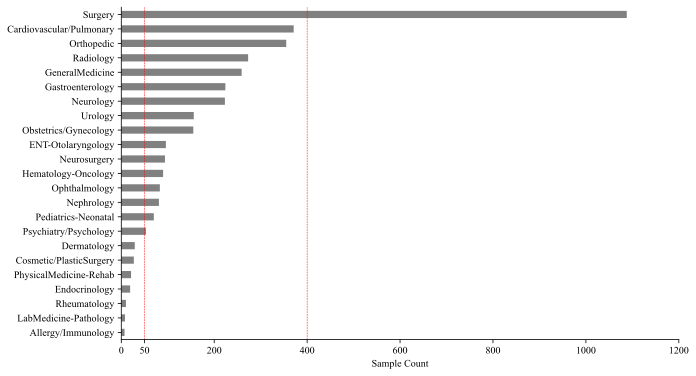

In [31]:
plt.style.use('default')
plt.rc('font', family='Times New Roman', weight='normal', size=10)

# Create a bar plot of the medical_specialty categories
counts = mtsamples['medical_specialty'].value_counts()
ax = counts.plot(kind='barh', figsize=(10, 6), color= 'grey')

plt.xlabel('Sample Count')
ax = plt.gca() 
ax.spines[['right', 'top']].set_visible(False)
ax.invert_yaxis()
plt.axvline(x=50, color='r', linestyle='--', linewidth=0.5)
plt.axvline(x=400, color='r', linestyle='--', linewidth=0.5)

# Add a specific tick and label at the value 50 on the x-axis
current_ticks = ax.get_xticks()  # Get current tick locations
current_labels = [int(tick) for tick in current_ticks]  # Get current tick labels as integers
if 50 not in current_ticks:
    current_ticks = np.append(current_ticks, 50)  # Add the tick for 50
    current_labels.append('50')  # Label specifically for the tick at 50
ax.set_xticks(current_ticks)  # Set new tick positions
ax.set_xticklabels(current_labels)  # Set new tick labels

plt.show()

#### **1.3.** Target Variable balancing

In [19]:
# Class balancing - delete classes with less than 50 samples
class_counts = mtsamples['medical_specialty'].value_counts()
classes_to_delete = class_counts[class_counts < 50].index
mtsamples_del = mtsamples[~mtsamples['medical_specialty'].isin(classes_to_delete)]

# Print deleted classes
print(f"Deleted classes: {classes_to_delete}")

# Undersampling Surgery class
surgery = mtsamples_del[mtsamples_del['medical_specialty'] == 'Surgery']
## Choose 400 random samples from Surgery class
surgery = surgery.sample(n=400, random_state=123)
other_specialties = mtsamples_del[mtsamples_del['medical_specialty'] != 'Surgery']
mtsamples_final = pd.concat([surgery, other_specialties])
mtsamples_final.reset_index(drop=True, inplace=True)

# Analyze the distribution of the medical_speciality categories after pre-processing
print(mtsamples_final['medical_specialty'].value_counts())

Deleted classes: Index(['LabMedicine-Pathology', 'Allergy/Immunology'], dtype='object', name='medical_specialty')
medical_specialty
Surgery                     400
Cardiovascular/Pulmonary    371
Orthopedic                  355
Radiology                   273
GeneralMedicine             259
Gastroenterology            224
Neurology                   223
Urology                     156
Obstetrics/Gynecology       155
ENT-Otolaryngology           96
Neurosurgery                 94
Hematology-Oncology          90
Ophthalmology                83
Nephrology                   81
Pediatrics-Neonatal          70
Psychiatry/Psychology        53
Dermatology                  29
Cosmetic/PlasticSurgery      27
PhysicalMedicine-Rehab       21
Endocrinology                19
Rheumatology                 10
Name: count, dtype: int64


#### **1.4.** Text Normalization

In [20]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

def clean_text(text):
    # Replace punctuation with a space
    text = ''.join([char if char.isalnum() else ' ' for char in text])

    # Split the text into words
    words = text.split()

    # Remove digits and stopwords
    words = [word for word in words if not word.isdigit() and word.lower() not in STOP_WORDS]

    # Lowercase all words
    words = [word.lower() for word in words]
    
    # Join the words back into a single string
    text = ' '.join(words)
    return text

# Apply the function to the transcription column
mtsamples_final['transcription_cleaned'] = mtsamples_final['transcription'].apply(clean_text)

#### **1.5.** Lemmatization and Stemming

In [21]:
# Apply stemming and lemmatization
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Create a stemmer object
stemmer = PorterStemmer()

# Create a lemmatizer object
lemmatizer = WordNetLemmatizer()

# Define a function that performs both stemming and lemmatization
def stem_and_lemmatize_text(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words), ' '.join(stemmed_words)

# Apply the function to the transcription column
mtsamples_final['lemma'], mtsamples_final['stem'] = zip(*mtsamples_final['transcription_cleaned'].apply(stem_and_lemmatize_text))

#### **1.6.** Tokenization

In [22]:
# Tokenize the text
from nltk.tokenize import word_tokenize

# Tokenize the text
mtsamples_final['tokens'] = mtsamples_final['transcription_cleaned'].apply(word_tokenize)
mtsamples_final['tokens_lemma'] = mtsamples_final['lemma'].apply(word_tokenize)
mtsamples_final['tokens_stem'] = mtsamples_final['stem'].apply(word_tokenize)

In [24]:
# Save the pre-processed data
mtsamples_final.to_csv('mtsamples_preprocessed.csv', index=False)

## **2.** Document Processing

#### **2.1** Document representation with CountVectorizer

In [36]:
# Use CountVectorizer to convert the text data into a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(strip_accents = 'unicode', # remove accents
                             lowercase = False, # convert to lowercase
                             ngram_range = (1, 1), # set the lower and upper boundary of the range for different word n-grams unigrams
                             max_df = 0.8, # ignore terms that have a document frequency strictly higher than the given threshold
                             max_features = 10000 # only consider the top max_features ordered by term frequency across the corpus
                            )

X_count = vectorizer.fit_transform(mtsamples_final['lemma'])

#### **2.2.** Document representation with TfidfVectorizer

In [37]:
# Use TfidfVectorizer to convert the text data into a matrix
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents = 'unicode', # remove accents
                             lowercase = False, # convert to lowercase
                             ngram_range = (1, 3), # set the lower and upper boundary of the range for different word n-grams unigrams
                             max_df = 0.8, # ignore terms that have a document frequency strictly higher than the given threshold
                             min_df = 1, # ignore terms that have a document frequency strictly lower than the given threshold
                             max_features = 3000, # only consider the top max_features ordered by term frequency across the corpus
                            )

X_TF = vectorizer.fit_transform(mtsamples_final['stem'])

#### **2.2.** Document representation with Word2Vec

In [38]:
# Use word2vec to convert the text data into embedding vectors
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Train the Word2Vec model
w2v_model = Word2Vec(sentences=mtsamples_final['tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Function which converts a document into a embedding vector
def vectorize(words):
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_w2v = np.array([vectorize(doc) for doc in mtsamples_final['tokens']])

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


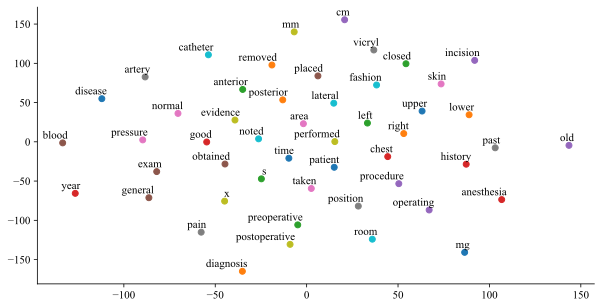

In [39]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Select a subset of words (for visualization purposes)
words = list(w2v_model.wv.key_to_index)[:50]  # Adjust the number as needed
word_vectors = np.array([w2v_model.wv[word] for word in words])

# Reduce dimensions using PCA first
n_components = min(word_vectors.shape[0], word_vectors.shape[1]) - 1
pca = PCA(n_components=n_components)
word_vectors_pca = pca.fit_transform(word_vectors)

# Apply t-SNE to the PCA-reduced data
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(word_vectors_pca)

# Plotting the results
plt.figure(figsize=(10, 5))
plt.style.use('default')
plt.rc('font', family='Times New Roman', weight='normal', size=11)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

for i, word in enumerate(words):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.annotate(word,
                 xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    
plt.show()

In [40]:
# Same as before but with a pre-trained Word2Vec model
from gensim.models import KeyedVectors
import gensim.downloader as api

# Load pre-trained Word2Vec model
w2v2_model = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data

# Function which converts a list of words into an embedding vector
def vectorize(words):
    words_vecs = [w2v2_model[word] for word in words if word in w2v2_model.key_to_index]
    if not words_vecs:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_w2v2 = np.array([vectorize(tokens) for tokens in mtsamples_final['tokens']])

#### **2.3** Document representation with sBERT

In [41]:
from sentence_transformers import SentenceTransformer

# Load pre-trained SentenceTransformer model
sb_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode the text data
X_bert = sb_model.encode(mtsamples_final['transcription_cleaned'])

## **3.** Classification Model Training
#### **3.1.** Multinomial Naive Bayes (for sparse matrices)

In [42]:
# Shuffle and split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_TF, mtsamples_final['medical_specialty'], test_size=0.25, random_state=123)

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn import metrics

# List of labels (medical specialties)
labels = mtsamples_final['medical_specialty'].unique()

# Train the Multinomial Naive Bayes model
nb = MultinomialNB()
nb_model = nb.fit(x_train, y_train)

# Predict the test set
y_pred1 = nb_model.predict(x_test)

# Classification report
print(classification_report(y_test, y_pred1))
print(metrics.confusion_matrix(y_test, y_pred1))

                          precision    recall  f1-score   support

Cardiovascular/Pulmonary       0.55      0.62      0.58        97
      ENT-Otolaryngology       1.00      0.06      0.11        18
        Gastroenterology       0.83      0.54      0.65        63
         GeneralMedicine       0.38      0.91      0.54        66
     Hematology-Oncology       0.00      0.00      0.00        23
              Nephrology       0.00      0.00      0.00        24
               Neurology       0.54      0.46      0.50        57
            Neurosurgery       0.00      0.00      0.00        22
   Obstetrics/Gynecology       0.67      0.53      0.59        30
           Ophthalmology       1.00      0.33      0.50        21
              Orthopedic       0.58      0.69      0.63        98
     Pediatrics-Neonatal       0.00      0.00      0.00        15
   Psychiatry/Psychology       1.00      0.14      0.25         7
               Radiology       0.33      0.25      0.28        73
         

c:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **3.2.** Gaussian Naive Bayes (for dense matrices)

In [43]:
# Shuffle and split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_w2v, mtsamples_final['medical_specialty'], test_size=0.25, random_state=123)

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

# List of labels (medical specialties)
labels = mtsamples_final['medical_specialty'].unique()

# Train the Multinomial Naive Bayes model
gnb = GaussianNB()
gnb_model = gnb.fit(x_train, y_train)

# Predict the test set
y_pred1 = gnb_model.predict(x_test)

# Classification report
print(classification_report(y_test, y_pred1))
print(metrics.confusion_matrix(y_test, y_pred1))

                          precision    recall  f1-score   support

Cardiovascular/Pulmonary       0.60      0.28      0.38        97
      ENT-Otolaryngology       0.06      0.06      0.06        18
        Gastroenterology       0.63      0.35      0.45        63
         GeneralMedicine       0.44      0.74      0.55        66
     Hematology-Oncology       0.29      0.22      0.25        23
              Nephrology       0.00      0.00      0.00        24
               Neurology       0.35      0.40      0.38        57
            Neurosurgery       0.24      0.55      0.33        22
   Obstetrics/Gynecology       0.25      0.03      0.06        30
           Ophthalmology       0.46      0.52      0.49        21
              Orthopedic       0.42      0.05      0.09        98
     Pediatrics-Neonatal       0.11      0.13      0.12        15
   Psychiatry/Psychology       0.27      1.00      0.42         7
               Radiology       0.41      0.56      0.47        73
         

#### **3.3.** Support Vector Machine

                          precision    recall  f1-score   support

Cardiovascular/Pulmonary       0.56      0.78      0.65        97
      ENT-Otolaryngology       0.67      0.56      0.61        18
        Gastroenterology       0.70      0.78      0.74        63
         GeneralMedicine       0.56      0.71      0.63        66
     Hematology-Oncology       0.57      0.17      0.27        23
              Nephrology       0.69      0.46      0.55        24
               Neurology       0.50      0.53      0.51        57
            Neurosurgery       0.11      0.09      0.10        22
   Obstetrics/Gynecology       0.62      0.87      0.72        30
           Ophthalmology       0.73      0.76      0.74        21
              Orthopedic       0.55      0.68      0.61        98
     Pediatrics-Neonatal       0.45      0.33      0.38        15
   Psychiatry/Psychology       0.83      0.71      0.77         7
               Radiology       0.16      0.10      0.12        73
         

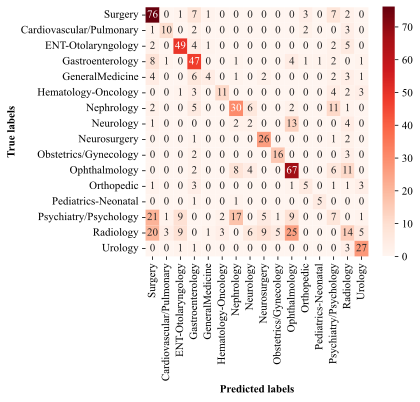

In [44]:
# Shuffle and split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_bert, mtsamples_final['medical_specialty'], test_size=0.25, random_state=123)

from sklearn.svm import SVC

# Train the Support Vector Machine (SVM) model
svm = SVC(C = 1.0,
          kernel = 'rbf',
          random_state = 123) 

svm_model = svm.fit(x_train, y_train)

# Predict the test set
y_pred2 = svm_model.predict(x_test)

# Classification report
print(classification_report(y_test, y_pred2))

# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred2)

labels = mtsamples_final['medical_specialty'].unique()

# Plot the confusion matrix
plt.figure(figsize=(5, 4.5))
plt.rc('font', family='Times New Roman', weight='normal')
plt.gca().spines['right'].set_visible(False)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels', weight='bold')
plt.ylabel('True labels', weight='bold')
plt.show()

#### **3.5.** Fine-tuned Transformer Model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer 
from torch.utils.data import Dataset, DataLoader 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
import torch

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(mtsamples_final['transcription_cleaned'], mtsamples_final['medical_specialty'], test_size=0.25, random_state=123)

# If your labels are string types or not in numeric form, you might need to encode them
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Load a Pre-trained Model and Tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(mtsamples_final['medical_specialty'].unique()))

# Tokenize Your Data
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=500, return_tensors="pt")
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=500, return_tensors="pt")

class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).long()  # Convert to Long type
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, y_train)
test_dataset = MyDataset(test_encodings, y_test)

# Prepare the model for training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.train()

# Train the model
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optim = torch.optim.Adam(model.parameters(), lr=5e-5)

for epoch in range(3):
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()

model.eval()

In [ ]:
# Classification report for the test set
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

y_pred = []
y_true = []
y_labels = mtsamples_final['medical_specialty'].unique()

for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    y_pred.extend(torch.argmax(logits, 1).tolist())
    y_true.extend(labels.tolist())
    
print(classification_report(y_true, y_pred, labels=label_encoder.transform(y_labels), target_names=y_labels))